Whether there is a trade-off of failure length between tasks when guidance is shown. 

Do the transition diagrams but only for transitions that happen for failures longer than grace period without looking. 





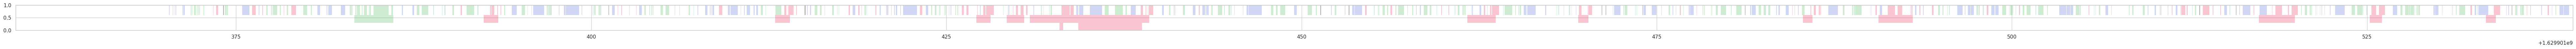

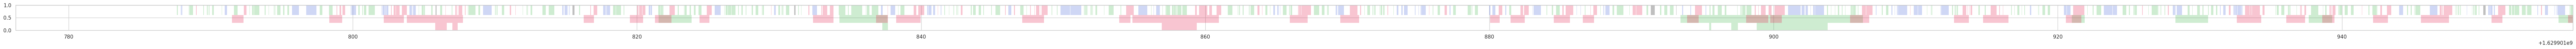

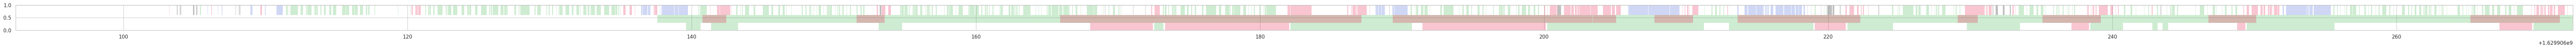

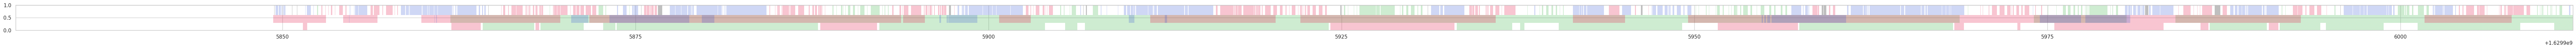

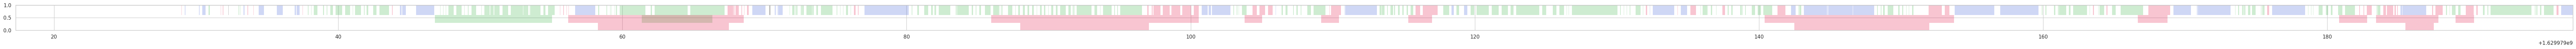

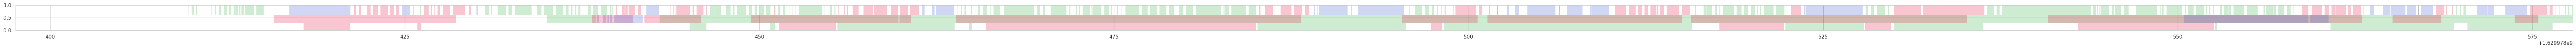

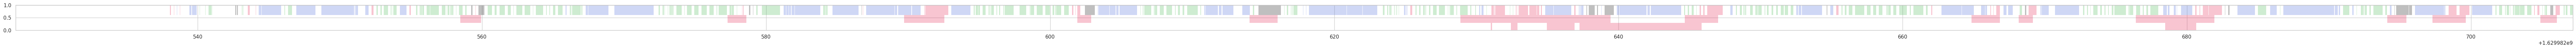

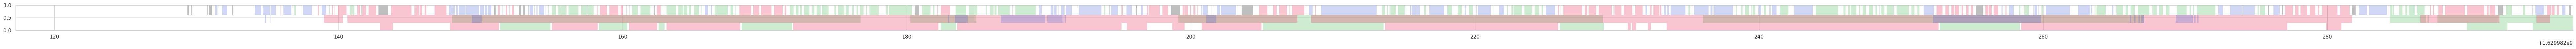

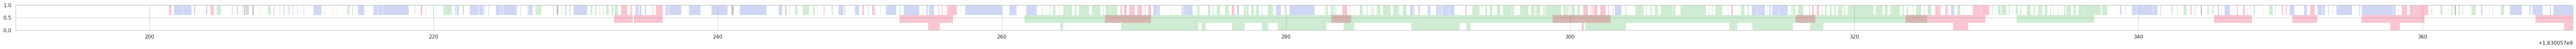

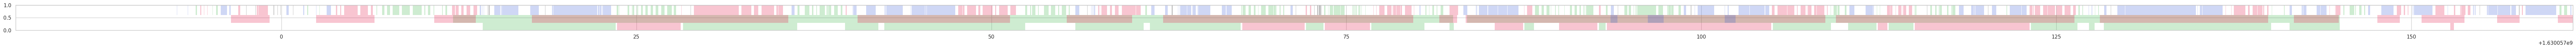

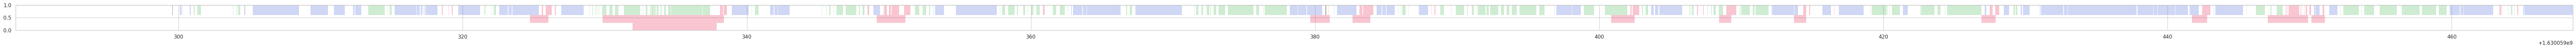

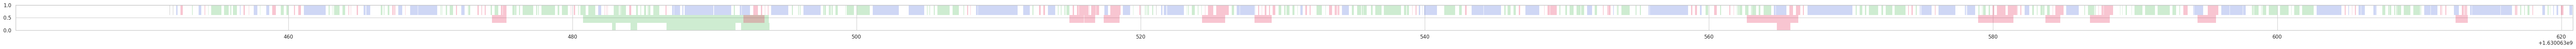

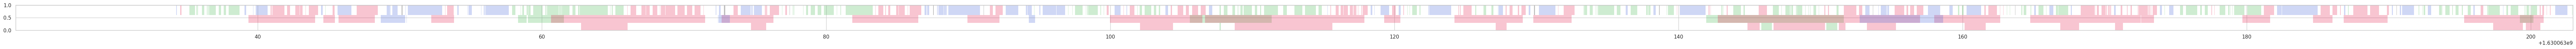

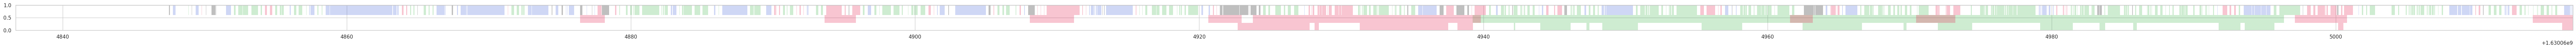

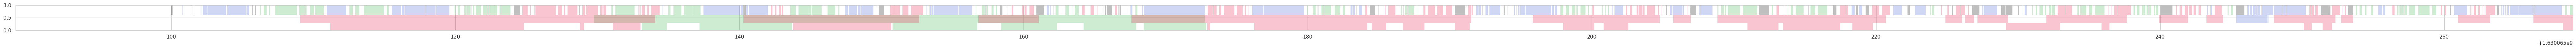

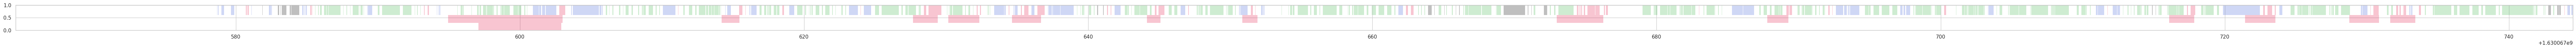

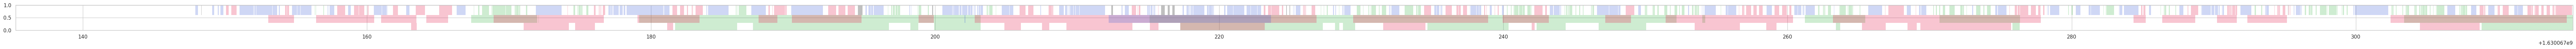

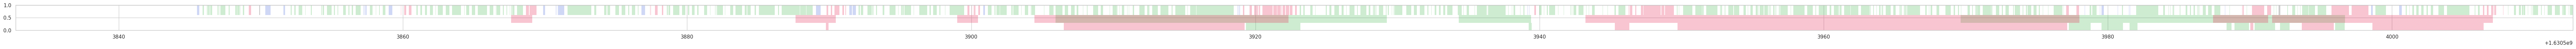

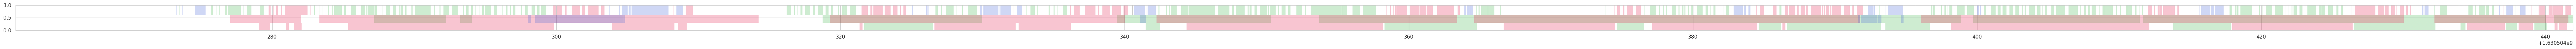

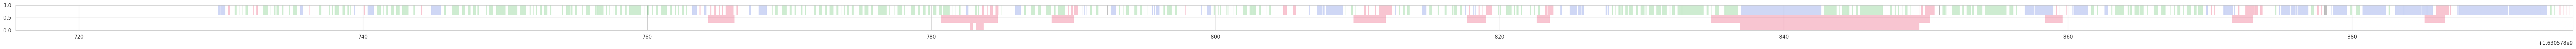

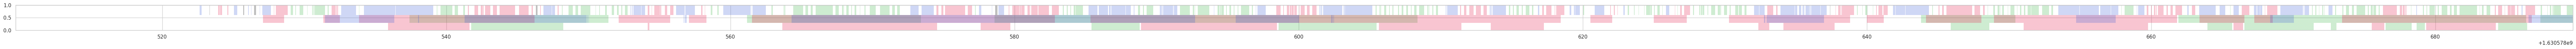

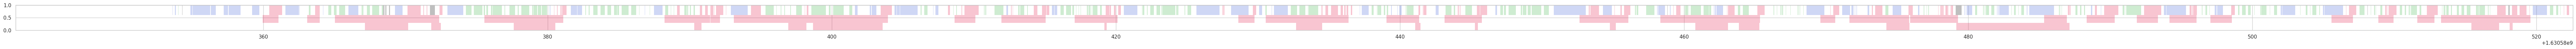

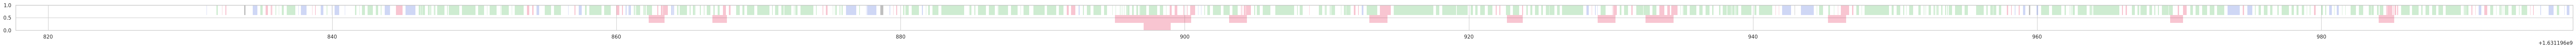

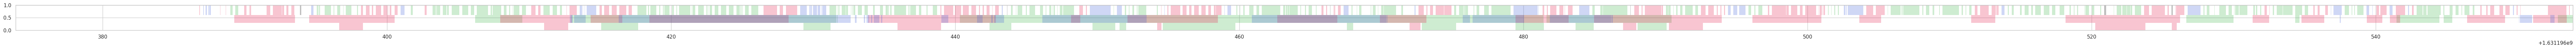

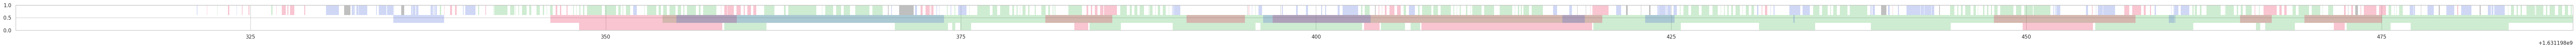

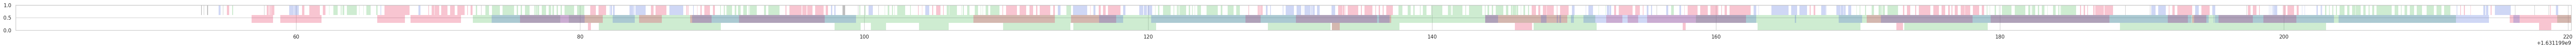

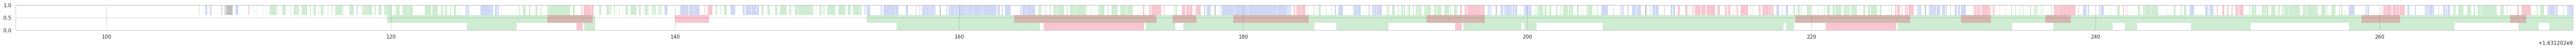

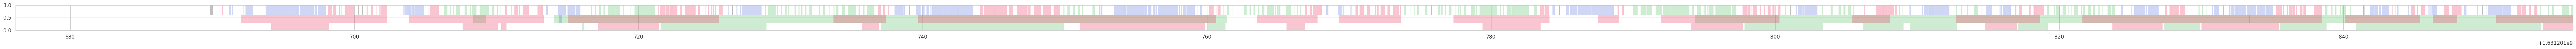

   participant  trial  guidance_count  looking@failure  abandon@failure  \
0          P01  icuaA               2                0                0   
1          P01  icuaB               7                3                3   
2          P02  icuaA              21               17                8   
3          P02  icuaB              27                9                5   
4          P04  icuaA               4                0                0   
5          P04  icuaB              19               17               16   
6          P05  icuaA               5                0                0   
7          P05  icuaB              27               12                9   
8          P06  icuaA              18                3                0   
9          P06  icuaB              27                9                7   
10         P07  icuaA               1                0                0   
11         P08  icuaA               5                0                0   
12         P08  icuaB    

In [12]:
# When guidance is shown how many things are in failure?, 
# also is where they are looking currently in failure?

import matplotlib.pyplot as plt
import icua_analysis as ia
import pandas as pd
import numpy as np
from itertools import islice

def plot_guidance_info(data):
    # plot guidance intervals
    fig = plt.figure(figsize=(100,1))
    gintervals = ia.get_guidance_intervals(data)
    ia.plot_task_intervals(gintervals, ymin=0.0, ymax=0.3)
    
    fintervals = ia.get_failure_intervals(data)
    ia.plot_task_intervals(fintervals, ymin=0.3, ymax=0.6)
    
    lintervals = ia.get_fixation_intervals(data)
    ia.plot_task_intervals(lintervals, ymin=0.6, ymax=1)
    
    plt.gca().set_xlim(data['start_time'], data['finish_time'])
    return fig
    
def get_guidance_info(data, zero_start_time=True):
    # this will get information about when guidance happens - where failures are and where the participant is looking.
    # failure@{task} tells us which task is in failure when guidance is initiated (i.e. on 't1')
    # looking@       tells us which task the participant is looking at when guidance is initiated (i.e. on 't1') 
    # values of "N" mean "no task"
    gintervals = ia.get_guidance_intervals(data)    
    fintervals = ia.get_failure_intervals(data)    
    lintervals = ia.get_fixation_intervals(data)    
    # get the indicies of the failure interval that contains the
    # ia.get_non_overlapping_interval_indices requires that fintervals are non-overlapping. 
    # We can ensure this by grouping by task.
    result = pd.DataFrame(columns=['t1', 't2', 'task'])
    result[['t1', 't2', 'task']] = gintervals[['t1', 't2', 'task']]                           
    for task in ia.TASKS:
        ftask_intervals = fintervals[fintervals['task'] == task]
        findex = ia.get_non_overlapping_interval_indices(ftask_intervals[['t1','t2']].to_numpy(), gintervals['t1'].to_numpy())
        fail = findex >= 0
        result[f'failure@{task}'] = fail # convert to a bool array
        
        # was the task resolved before following guidance?
        abandoned = np.full(fail.shape, False, dtype=bool)
        fends = ftask_intervals.iloc[findex[fail]]['t2'].to_numpy()
        # if the end of the failure is greater than the end of the guidance, they switched task during a failure
        abandoned = np.full(fail.shape, False, dtype=bool)
        abandoned[fail] = fends > gintervals['t2'].to_numpy()[fail]
        result[f'abandon@{task}'] = abandoned
        #print(result[f'abandoned@{task}'], fends, gintervals['t2'].to_numpy())
    
    lindex = ia.get_non_overlapping_interval_indices(lintervals[['t1', 't2']].to_numpy(), gintervals['t1'].to_numpy())
    result['looking@'] = lintervals.iloc[lindex]['task'].to_numpy()
    result['multi-failure'] = result[[f'failure@{task}' for task in ia.TASKS]].sum(axis=1)
        
    # is the task the participant currently looking at in failure? this means that they may not want to follow the guidance before fixing their task.
    if len(result) > 0: # prevents error with apply on empty data frame
        result['failure@N'] = False # temporary for the computation of 'looking@failure'
        result['abandon@N'] = False # temporary for the computation of 'abandon@failure'
        # whether the task they are currently looking at is in failure
        result['looking@failure'] = result.apply(lambda row: row[f'failure@{row["looking@"]}'], axis=1)
        
        # this means they abandoned their current task while it was in failure in favour of another task
        result['abandon@failure'] = result.apply(lambda row: row[f'abandon@{row["looking@"]}'], axis=1)
        result = result.drop(columns=['failure@N', 'abandon@N'])
    else:
        result['looking@failure'] = []
        result['abandon@failure'] = []
    
    if zero_start_time:
        result[['t1', 't2']] -= data['start_time']
    return result


result = pd.DataFrame(columns=['participant', 'trial', 'guidance_count', 'looking@failure', 'abandon@failure', 'multi-failure'])

for (par, trial), data in islice(ia.load_tabularised().has_eyetracking().has_guidance(), 1000):
    if (par == "P07" and trial == "icuaB") or (par == "P18" and trial == "icuaA"): # these have eyetracking issues
        continue
    
    gdata = get_guidance_info(data)
    #print(par, trial)

    #print(gdata[['abandon@F',  'abandon@S',  'abandon@T']])
    #print(gdata[['failure@F',  'failure@S',  'failure@T', 'looking@', 'looking@failure', 'abandon@failure']])
    
    result.loc[len(result)] = [par, trial, len(gdata), 
                               gdata['looking@failure'].sum(), # how often they are looking at a task that is currently in failure when guidance is shown
                               gdata['abandon@failure'].sum(), # how often they abandon a currently failing task in favour of guidance
                               (gdata['multi-failure'] > 1).sum()]
    plot_guidance_info(data)
    plt.show()
    
print(result)
    


<Figure size 640x480 with 0 Axes>

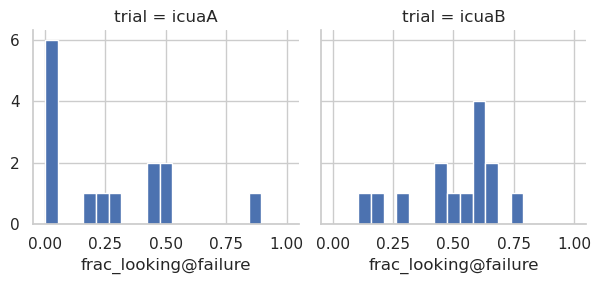

<Figure size 640x480 with 0 Axes>

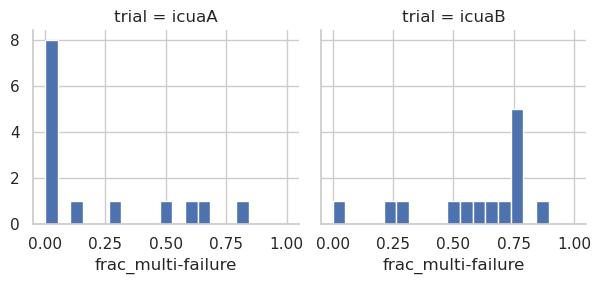

<Figure size 640x480 with 0 Axes>

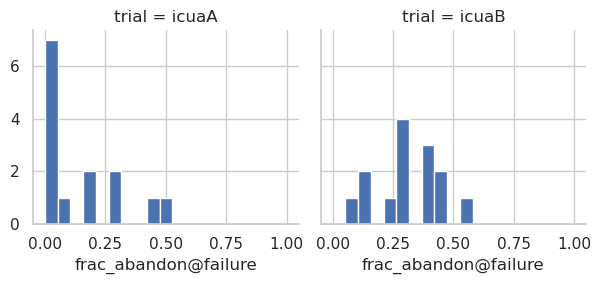

In [8]:
import seaborn as sns
import numpy as np

# check where participants are looking at a given task that is in failure at the moment guidance 
# for another task is shown. 
result["frac_looking@failure"] = result['looking@failure'] / result['guidance_count']
result["frac_abandon@failure"] = result['abandon@failure'] / result['guidance_count']

fig = plt.figure()
sns.set(style="whitegrid")
g = sns.FacetGrid(result, col="trial", col_wrap=3)
g.map(plt.hist, "frac_looking@failure", bins=np.linspace(0,1,20))  # You can adjust the number of bins as needed
plt.show()

# Summary: more often in the hard, the participant is dealing with the case where they are looking at one 
# failure while getting guidance for another failure. They must decide whether to switch.

# ------------------------------------------- # 

# check where participants are dealing with multiple failures during guidance - guidance should only show for one
# (NOTE: this happens in all cases but one, due a bug in the simulation).
result["frac_multi-failure"] = result['multi-failure'] / result['guidance_count']

fig = plt.figure()
sns.set(style="whitegrid")
g = sns.FacetGrid(result, col="trial", col_wrap=3)
g.map(plt.hist, "frac_multi-failure", bins=np.linspace(0,1,20))  # You can adjust the number of bins as needed
plt.show()

# Summary: result is similar, there are more instances of simultaneous failures in hard.

# ------------------------------------------- # 

# Check how often a task that they are looking at that is current in failure is abandoned in favour of guidance
fig = plt.figure()
sns.set(style="whitegrid")
g = sns.FacetGrid(result, col="trial", col_wrap=3)
g.map(plt.hist, "frac_abandon@failure", bins=np.linspace(0,1,20))  # You can adjust the number of bins as needed
plt.show()

# Conclusions:

# 1. We might expect to see some performance improvement in Easy due to participants "missing" a failure while 
# looking at a task that is not currently failing.

# 2. It is unlikely that we will see an improvement in performance for hard because there is a 
# trade off happening with task failures. When they switch task, they may be abandoning their currently failing task

# COMMENTS TODO

# It would be nice to see how often a task is resolved BEFORE a switch is made, and how often the participant 
# abandons their current task in favour of the guidance.





<Figure size 640x480 with 0 Axes>

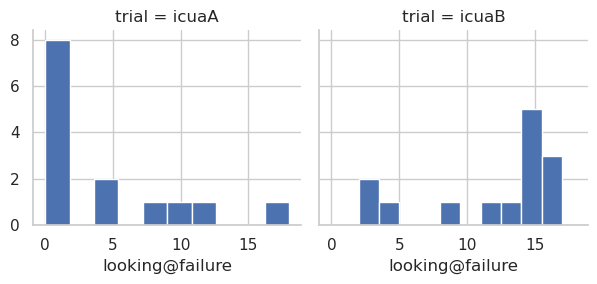

<Figure size 640x480 with 0 Axes>

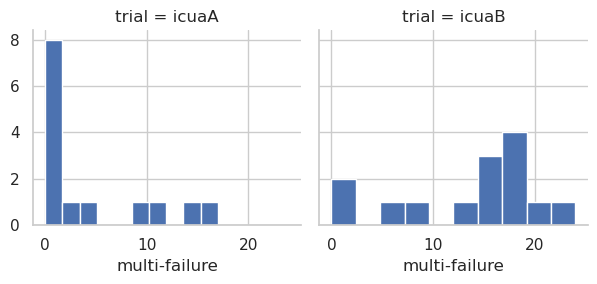

<Figure size 640x480 with 0 Axes>

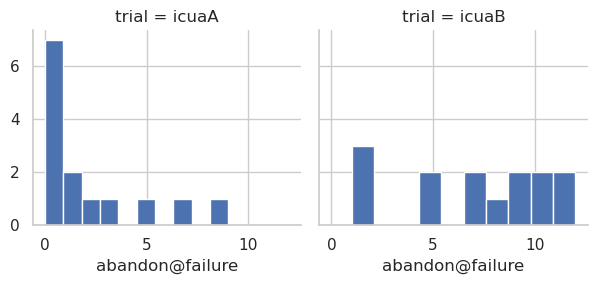

In [10]:
import seaborn as sns
import numpy as np

# check where participants are looking at a given task that is in failure at the moment guidance 
# for another task is shown. 
result["frac_looking@failure"] = result['looking@failure'] / result['guidance_count']
result["frac_abandon@failure"] = result['abandon@failure'] / result['guidance_count']

fig = plt.figure()
sns.set(style="whitegrid")
g = sns.FacetGrid(result, col="trial", col_wrap=3)
g.map(plt.hist, "looking@failure")  # You can adjust the number of bins as needed
plt.show()

# Summary: more often in the hard, the participant is dealing with the case where they are looking at one 
# failure while getting guidance for another failure. They must decide whether to switch.

# ------------------------------------------- # 

# check where participants are dealing with multiple failures during guidance - guidance should only show for one
# (NOTE: this happens in all cases but one, due a bug in the simulation).
result["frac_multi-failure"] = result['multi-failure'] / result['guidance_count']

fig = plt.figure()
sns.set(style="whitegrid")
g = sns.FacetGrid(result, col="trial", col_wrap=3)
g.map(plt.hist, "multi-failure")  # You can adjust the number of bins as needed
plt.show()

# Summary: result is similar, there are more instances of simultaneous failures in hard.

# ------------------------------------------- # 

# Check how often a task that they are looking at that is current in failure is abandoned in favour of guidance
fig = plt.figure()
sns.set(style="whitegrid")
g = sns.FacetGrid(result, col="trial", col_wrap=3)
g.map(plt.hist, "abandon@failure")  # You can adjust the number of bins as needed
plt.show()

# Conclusions:

# 1. We might expect to see some performance improvement in Easy due to participants "missing" a failure while 
# looking at a task that is not currently failing.

# 2. It is unlikely that we will see an improvement in performance for hard because there is a 
# trade off happening with task failures. When they switch task, they may be abandoning their currently failing task

# COMMENTS TODO

# It would be nice to see how often a task is resolved BEFORE a switch is made, and how often the participant 
# abandons their current task in favour of the guidance.



